In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/road_segmentation.ipynb)

# Road Segmentation

In this example we are going to train a Deep Learning model to find roads in satellite imagery, following the work [here](https://github.com/aavek/Satellite-Image-Road-Segmentation/tree/main?tab=readme-ov-file).

## Dataset

The dataset we are going to use is the [Deep Globe Road Extraction](https://www.eotdl.com/datasets/DeepGlobeRoadExtraction) dataset. It contains 6226 satellite imagery in RGB, size 1024x1024, at 50cm pixel resolution, collected by DigitalGlobe's satellite.

> We are going to download the dataset from the [EOTDL](https://www.eotdl.com/), so you will need to install the library with `pip install eotdl`.

In [2]:
from pytorch_eo.datasets import DeepGlobeRoadExtraction

ds = DeepGlobeRoadExtraction(batch_size=5)

ds.setup()

In [3]:
ds.df

image  \
0     data/DeepGlobeRoadExtraction/train/100034_sat.jpg   
1     data/DeepGlobeRoadExtraction/train/100081_sat.jpg   
2     data/DeepGlobeRoadExtraction/train/100129_sat.jpg   
3     data/DeepGlobeRoadExtraction/train/100703_sat.jpg   
4     data/DeepGlobeRoadExtraction/train/100712_sat.jpg   
...                                                 ...   
6221  data/DeepGlobeRoadExtraction/train/999431_sat.jpg   
6222  data/DeepGlobeRoadExtraction/train/999531_sat.jpg   
6223  data/DeepGlobeRoadExtraction/train/999667_sat.jpg   
6224  data/DeepGlobeRoadExtraction/train/999764_sat.jpg   
6225   data/DeepGlobeRoadExtraction/train/99995_sat.jpg   

                                                   mask  
0     data/DeepGlobeRoadExtraction/train/100034_mask...  
1     data/DeepGlobeRoadExtraction/train/100081_mask...  
2     data/DeepGlobeRoadExtraction/train/100129_mask...  
3     data/DeepGlobeRoadExtraction/train/100703_mask...  
4     data/DeepGlobeRoadExtraction/train/100712_mask...  
...                                                 ...  
6221  data/DeepGlobeRoadExtraction/train/999431_mask...  
6222  data/DeepGlobeRoadExtraction/train/999531_mask...  
6223  data/DeepGlobeRoadExtraction/train/999667_mask...  
6224  data/DeepGlobeRoadExtraction/train/999764_mask...  
6225  data/DeepGlobeRoadExtraction/train/99995_mask.png  

[6226 rows x 2 columns]

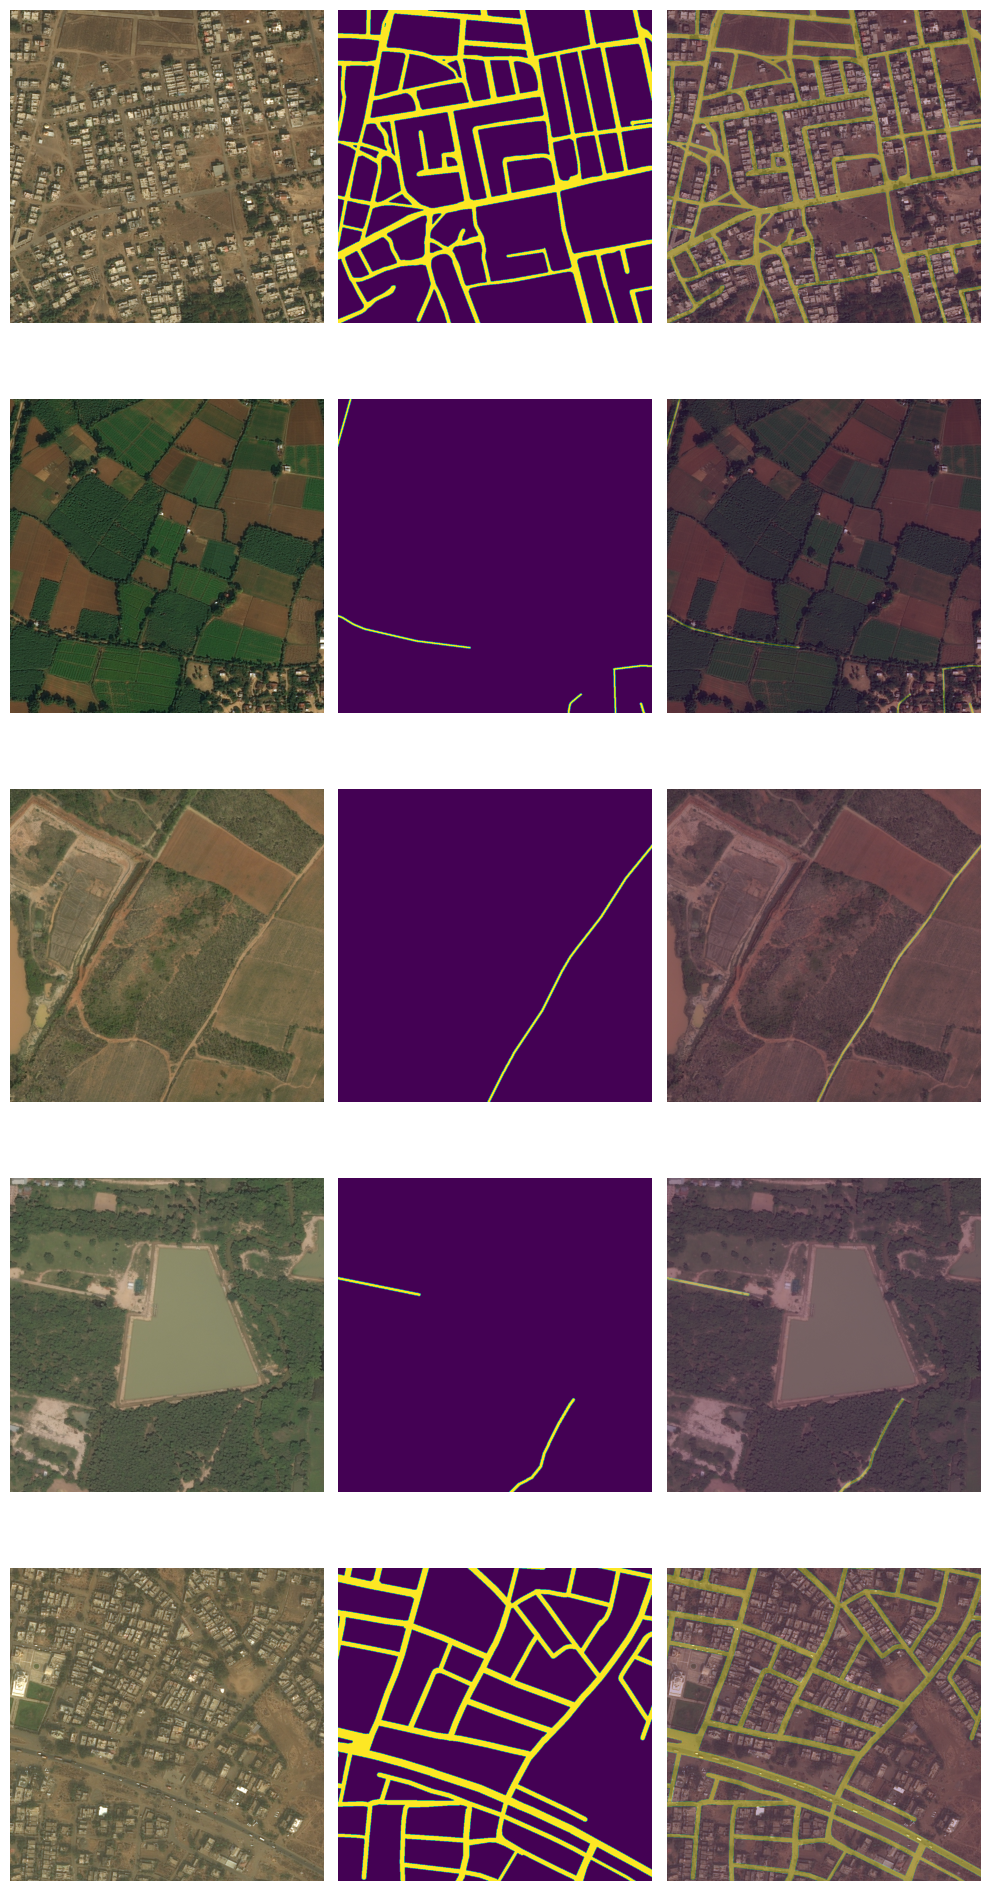

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

batch = next(iter(ds.train_dataloader()))
imgs, masks = batch['image'], batch['mask']

imgs = rearrange(imgs, 'b c h w -> b h w c')
masks = masks.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    ax.imshow(mask)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(img)
    ax.imshow(mask, alpha=0.3)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Training

We are goint to train a U-Net model, using data augmentation.

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# data augmentation

def norm(x, **kwargs):
            return (x / 255.0).astype("float32")

def to_grey(x, **kwargs):
	return x[:1, ...]

train_trans = A.Compose([
    # flips
	A.HorizontalFlip(),
	A.VerticalFlip(),
	A.Transpose(),
    # rotate
	A.RandomRotate90(),
    # normalize
	A.Lambda(image=norm, mask=norm),
	ToTensorV2(transpose_mask=True),  
	A.Lambda(mask=to_grey),
])
        
val_trans = A.Compose([
	A.Lambda(image=norm, mask=norm),
	ToTensorV2(transpose_mask=True),  
	A.Lambda(mask=to_grey),
])

In [7]:
import segmentation_models_pytorch as smp


# hyperparameters

model = smp.Unet(
	encoder_name="resnet18", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
	encoder_weights="imagenet",  # imagenet
	in_channels=3,
	classes=1,
)

hparams = {
	'optimizer': 'Adam',
	'optim_params':
		{
			'lr': 3e-4,
		},
}

In [8]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_eo.tasks import ImageSegmentation

ds = DeepGlobeRoadExtraction(
	batch_size=8, # adjust to GPU memory
	num_workers=20, # adjust to CPU cores
	pin_memory=True
)

task = ImageSegmentation(
	model,
	hparams,
	num_classes=ds.num_classes,
)

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=10,
	# limit_train_batches=10,
	# limit_val_batches=10,
	logger=WandbLogger(project="deepglobe-road-extraction", name="unet-resnet50"),
	callbacks=[
		ModelCheckpoint(
			monitor="val_iou",
			mode="max",
			save_top_k=1,
			dirpath="checkpoints",
			filename="unet-resnet50-{epoch:02d}-{val_iou:.2f}",
		)
	]
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: earthpulse. Use `wandb login --relogin` to force relogin


/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/juan/Desktop/pytorch_eo/examples/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Unet              | 14.3 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Evaluate

We can visualize the outputs of the model.

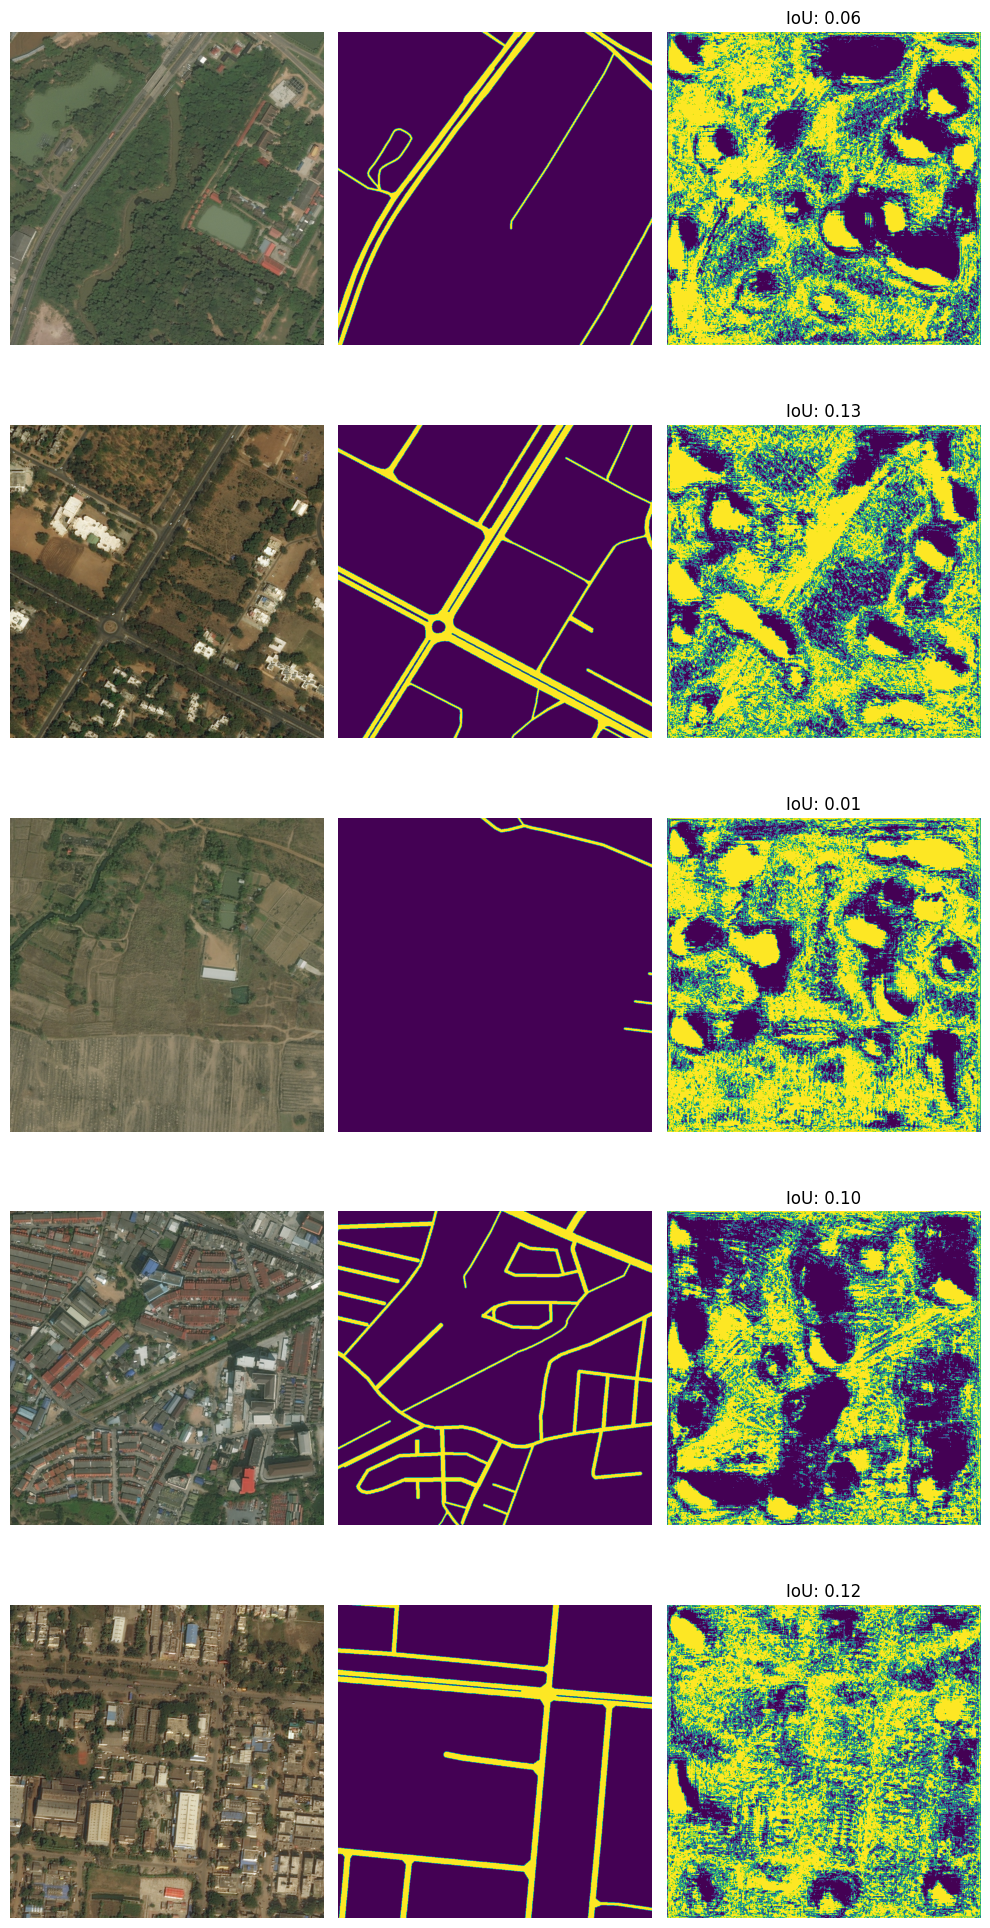

In [9]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from pytorch_eo.metrics.segmentation import iou

ds = DeepGlobeRoadExtraction(batch_size=5)
ds.setup()

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch['image'], batch['mask']

task.eval()
with torch.no_grad():
	preds = task.predict(batch) > 0.5

imgs = rearrange(imgs, 'b c h w -> b h w c')
masks = masks.squeeze(1)
preds = preds.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    ax.imshow(mask)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(pred)
    _iou = iou(pred.unsqueeze(0), mask.unsqueeze(0))
    ax.set_title(f"IoU: {_iou:.2f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Export model

Now we export the model to the ONNX format and ingest it to the EOTDL platform.

In [10]:
filepath = "data/model.onnx"

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch['image'], batch['mask']

task.to_onnx(filepath, imgs, export_params=True, dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/torch/onnx/utils.py:2029: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  warnings.warn(
/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/torch/onnx/utils.py:2029: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(
/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [11]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: imgs.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(5, 1, 1024, 1024)

In [16]:
from tqdm import tqdm

ious = []
pbar = tqdm(ds.val_dataloader())
for batch in pbar:
	ort_inputs = {input_name: batch['image'].numpy()}
	ort_outs = ort_session.run(None, ort_inputs)
	ious.append(iou(torch.tensor(ort_outs[0]), batch['mask']))
	pbar.set_description(f"mean IoU: {np.mean(ious):.4f}")

print(f"test iou: {np.mean(ious):.4f}")

  0%|          | 0/249 [00:00<?, ?it/s]

mean IoU: 0.0429:   4%|▍         | 11/249 [00:17<06:17,  1.59s/it]


KeyboardInterrupt: 

To ingest the model to the EOTDL platform, follow [these](https://www.eotdl.com/docs/models/ingest) instructions.